In [1]:
from imutils.object_detection import non_max_suppression
import numpy as np
import argparse
import time
import cv2
import os
import pytesseract
from matplotlib import pyplot as plt
%matplotlib inline
import urllib.request

In [8]:
args = {"east":"/home/janhavi/Documents/chatbot/Datasets/frozen_east_text_detection.pb", "min_confidence":0.1, "width":320, "height":320}

In [2]:
def resize(url):
    image = np.asarray(bytearray(urllib.request.urlopen(url).read()), dtype="uint8")
    image = cv2.imdecode(image, cv2.IMREAD_COLOR)
    orig = image.copy()
    (origH, origW) = image.shape[:2]
    (newW, newH) = (args['width'], args['height'])
    rW = origW / float(newW)
    rH = origH / float(newH)
    image = cv2.resize(image, (newW, newH))
    (H, W) = image.shape[:2]
    return orig, image, H, W, rH, rW

In [3]:
def EAST(image):
    blob = cv2.dnn.blobFromImage(image, 1.0, (W, H), (123.68, 116.78, 103.94), swapRB=True, crop=False)
    net = cv2.dnn.readNet("frozen_east_text_detection.pb")
    layerNames = ["feature_fusion/Conv_7/Sigmoid","feature_fusion/concat_3"]
    net.setInput(blob)
    (scores, geometry) = net.forward(layerNames)
    return (scores, geometry)    

In [4]:
def predictions(prob_score, geo):
    (numR, numC) = prob_score.shape[2:4]
    boxes = []
    confidence_val = []
    count = 0
    
    for y in range(0,numR):
        scoresData = prob_score[0,0,y]
        x0 = geo[0, 0, y]
        x1 = geo[0, 1, y]
        x2 = geo[0, 2, y]
        x3 = geo[0, 3, y]
        anglesData = geo[0, 4, y]
        
        for i in range(0,numC):
            if scoresData[i] < 0.8:
                continue

            (offX, offY) = (i * 3.99, y * 3.99)

            angle = anglesData[i]
            cos = np.cos(angle)
            sin = np.sin(angle)

            h = x0[i] + x2[i]
            w = x1[i] + x3[i]

            endX = int(offX + (cos * x1[i]) + (sin * x2[i]))
            endY = int(offY - (sin * x1[i]) + (cos * x2[i]))
            startX = int(endX - w)
            startY = int(endY - h)

            boxes.append((startX, startY, endX, endY))
            confidence_val.append(scoresData[i])
    
    return (boxes, confidence_val)

In [5]:
def predict_text(orig, image, rH, rW):
    scores, geometry = EAST(image)
    boxes, confidence_val = predictions(scores, geometry)
    boxes = non_max_suppression(np.array(boxes), probs = confidence_val)
    results = []
    words = []
    for (startX, startY, endX, endY) in boxes:
        startX = int(startX * rW)
        startY = int(startY * rH)
        endX = int(endX * rW)
        endY = int(endY * rH)

        r = orig[startY:endY, startX:endX]  
        gray = cv2.cvtColor(r, cv2.COLOR_BGR2GRAY)
        (thresh, blackAndWhiteImage) = cv2.threshold(gray, 127, 255, cv2.THRESH_BINARY)
        text = pytesseract.image_to_string(blackAndWhiteImage, config = "-l eng --oem 1 --psm 8")
        words.append(text)
    return words

In [ ]:
url = 'https://cdn-01.media-brady.com/store/stus/media/catalog/product/cache/4/image/85e4522595efc69f496374d01ef2bf13/1544622698/d/o/do-not-enter-traffic-signs-69137-lg.jpg'
orig, image, H, W, rH, rW = resize(url)
predict = predict_text(orig, image, rH, rW)

In [6]:
#Read image and save a copy of original with height and width
#url = 'https://cdn-01.media-brady.com/store/stus/media/catalog/product/cache/4/image/85e4522595efc69f496374d01ef2bf13/1544622698/d/o/do-not-enter-traffic-signs-69137-lg.jpg'
#url = 'https://dxd.group/sites/default/files/2019-02/street-name-sign.jpg'
url = 'https://www.team-bhp.com/forum/attachments/indian-car-scene/69590d1226627898-high-security-registration-plates-hsrp-india-d1.jpg'
image = np.asarray(bytearray(urllib.request.urlopen(url).read()), dtype="uint8")
image = cv2.imdecode(image, cv2.IMREAD_COLOR)
orig = image.copy()
(origH, origW) = image.shape[:2]

In [9]:
#set new height and width to default values of 320
#find ratio of new height/width to original height/width. This is used for finding bounding box on original image
(newW, newH) = (args['width'], args['height'])
rW = origW / float(newW)
rH = origH / float(newH)

In [10]:
#resize the image
image = cv2.resize(image, (newW, newH))
(H, W) = image.shape[:2]

In [11]:
#construct blob to pass to EAST model
blob = cv2.dnn.blobFromImage(image, 1.0, (W, H), (123.68, 116.78, 103.94), swapRB=True, crop=False)

In [12]:
#load the EAST model
net = cv2.dnn.readNet("frozen_east_text_detection.pb")

In [13]:
layerNames = ["feature_fusion/Conv_7/Sigmoid","feature_fusion/concat_3"]

In [14]:
net.setInput(blob)
(scores, geometry) = net.forward(layerNames)

In [15]:
(boxes, confidence_val) = predictions(scores, geometry)
boxes = non_max_suppression(np.array(boxes), probs = confidence_val)

In [16]:
pytesseract.pytesseract.tesseract_cmd = r'/usr/bin/tesseract'

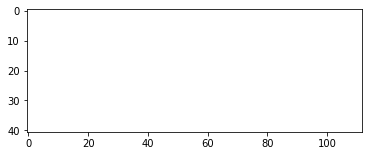

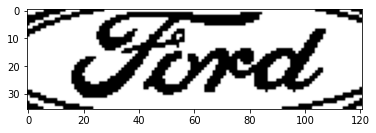

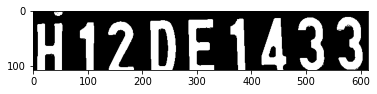

error: OpenCV(4.2.0) /io/opencv/modules/imgproc/src/color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'


In [17]:
results = []
words = []
for (startX, startY, endX, endY) in boxes:
    startX = int(startX * rW)
    startY = int(startY * rH)
    endX = int(endX * rW)
    endY = int(endY * rH)

    r = orig[startY:endY, startX:endX]  
    gray = cv2.cvtColor(r, cv2.COLOR_BGR2GRAY)
    (thresh, blackAndWhiteImage) = cv2.threshold(gray, 127, 255, cv2.THRESH_BINARY)
    plt.imshow(blackAndWhiteImage, cmap = 'Greys')
    plt.show()
    
    text = pytesseract.image_to_string(blackAndWhiteImage, config = "-l eng --oem 1 --psm 6")
    words.append(text)
    
    results.append(((startX, startY, endX, endY), text))
    

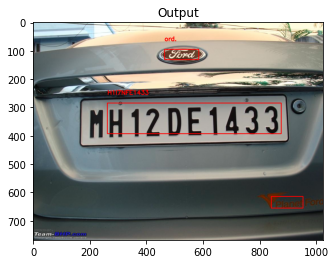

In [18]:
orig_image = orig.copy()
for ((startX, startY, endX, endY), text) in results:
    #print("{}\n".format(text))
    
    #text = "".join([x if ord(x) < 128 else "" for x in text]).strip()
    cv2.rectangle(orig_image, (startX, startY), (endX, endY), (255, 0, 0), 2)
    cv2.putText(orig_image, text, (startX, startY - 30), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 0, 0), 2)
    
plt.imshow(orig_image)
plt.title('Output')
plt.show()

In [19]:
words

['', 'ord.', 'H1I7NFE1433']